In [ ]:
# importing required libraries
import re
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
from nltk.stem.porter import *

%matplotlib inline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import gensim
import gc 

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
data_path = '/datasets/quotes_data/BalancedQuotesClean.csv'

In [ ]:
# read the dataset
df = pd.read_csv(data_path)
# view the top rows
df.head()

,quote,label
0,To sin offers repentance and forgiveness not t...,aspirations
1,Be calm in arguing for fierceness makes error ...,aspirations
2,For all of its uncertainty we cannot flee the ...,aspirations
3,The way that a handful of corporations in Los ...,aspirations
4,Dreams have only one owner at a time. That's w...,aspirations


In [ ]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [ ]:
# remove any handles (@user)
df['tidy_quote'] = np.vectorize(remove_pattern)(df['quote'], "@[\w]*")

# remove special characters, numbers, punctuations
df['tidy_quote'] = df['tidy_quote'].str.replace("[^a-zA-Z#]", " ")

df['tidy_quote'] = df['tidy_quote'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

tokenized_quote = df['tidy_quote'].apply(lambda x: x.split())

for i in range(len(tokenized_quote)):
    tokenized_quote[i] = ' '.join(tokenized_quote[i])

df['quote'] = tokenized_quote
del df['tidy_quote']
gc.collect()

0

In [ ]:
df.head()

,quote,label
0,offers repentance forgiveness offers only puni...,aspirations
1,calm arguing fierceness makes error fault trut...,aspirations
2,uncertainty cannot flee future,aspirations
3,that handful corporations Angeles dictate stor...,aspirations
4,Dreams have only owner time That dreamers lonely,aspirations


In [ ]:
df['category_id'] = df['label'].factorize()[0]
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)
df.tail()

,quote,label,category_id
42025,being good manager keeping people hate away fr...,work,4
42026,profession book writing makes horse racing see...,work,4
42027,actually about famous fourth division football...,work,4
42028,Tranquilizers work only follow advice bottle k...,work,4
42029,share work limited fact that work makes precious,work,4


In [ ]:
label_to_ix = {}
for label in df.label:
    for word in label.split():
        if word not in label_to_ix:
            label_to_ix[word]=len(label_to_ix)
labels_text = list(label_to_ix.keys())
num_labels = len(labels_text)
labels_text

['aspirations', 'emotional', 'personal', 'thoughtful', 'work']

In [ ]:
tfidf = TfidfVectorizer(lowercase= True, sublinear_tf=True, min_df=56, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=ENGLISH_STOP_WORDS)

features = tfidf.fit_transform(df.quote).toarray()
labels = df.category_id
features.shape

(42030, 1280)

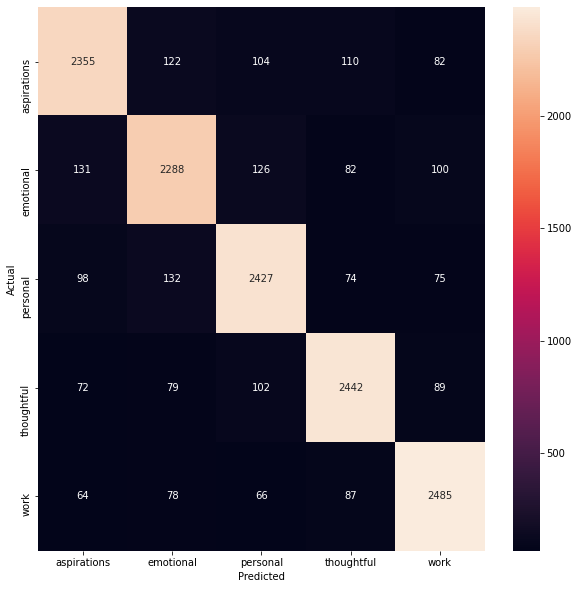

In [ ]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# from IPython.display import display

# for predicted in category_id_df.category_id:
#   for actual in category_id_df.category_id:
#     if predicted != actual and conf_mat[actual, predicted] >= 10:
#       print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
#       display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['label', 'quote']])
#       print('')

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=df['label'].unique()))

              precision    recall  f1-score   support

 aspirations       0.87      0.85      0.86      2773
   emotional       0.85      0.84      0.84      2727
    personal       0.86      0.86      0.86      2806
  thoughtful       0.87      0.88      0.88      2784
        work       0.88      0.89      0.89      2780

    accuracy                           0.86     13870
   macro avg       0.86      0.86      0.86     13870
weighted avg       0.86      0.86      0.86     13870



In [ ]:
# train test split
train, test = train_test_split(df, test_size = 0.2, stratify = df['category_id'], random_state=21)

# get the shape of train and test split.
train.shape, test.shape

((33624, 3), (8406, 3))

In [ ]:
# define the stages of the pipeline
pipeline = Pipeline(steps= [('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=56, norm='l2', 
                                                        encoding='latin-1', ngram_range=(1, 2), 
                                                        stop_words=ENGLISH_STOP_WORDS)),
                            ('model', LinearSVC())])

# fit the pipeline model with the training data                            
pipeline.fit(train.quote, train.category_id)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(encoding='latin-1', min_df=56,
                                 ngram_range=(1, 2),
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                     

In [ ]:
quote = ['amazing performer Very temperamental spent time trailer']

# predict the label using the pipeline
ans = pipeline.predict(quote)
print(labels_text[int(ans)])

emotional


In [ ]:
import joblib
from joblib import dump

# # dump the pipeline model
joblib.dump(pipeline, 'text_classification.pkl')
# dump(pipeline, filename="text_classification.joblib")

['text_classification.pkl']

In [ ]:
# # import joblib
# from joblib import load

# sample tweet text
quote = ['want talk about intelligence matters will however that intelligence community estimates should become public this city Congress']

# # load the saved pipleine model
# pipeline = load("text_classification.joblib")


modelp = open('text_classification.pkl','rb')
pipeline = joblib.load(modelp)


def predict(pipeline, quote, labels):
    # predict on the sample tweet text
    ans = pipeline.predict(quote)
    return labels_text[int(ans)]

resp = predict(pipeline, quote, labels)
resp


'thoughtful'